In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import os
if 'src' in os.getcwd():
    os.chdir('..')

from uncertainty.EDL import *
from helpers.data_handler import Dataset, DatasetPreprocessor

In [80]:
dataset = Dataset('diabetes')
dataset_preprocessor = DatasetPreprocessor(
    dataset=dataset,
    split=0.8,
    random_state=123,
    one_hot=True,
)


X_train_pd, X_test_pd, y_train, y_test = dataset_preprocessor.get_data()

# Convert to numpy
X_train, X_test = [x.to_numpy() for x in (X_train_pd, X_test_pd)]

def one_hot_encode(y):
    y = y.astype(int)
    y_onehot = np.zeros((y.size, y.max()+1))
    y_onehot[np.arange(y.size),y] = 1
    return y_onehot

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

In [81]:
seed = 432    
_X_train, _X_test, _y_train, _y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

_X_train = torch.tensor(_X_train, dtype=torch.float32)
_y_train = torch.tensor(_y_train, dtype=torch.float32)
_X_test = torch.tensor(_X_test, dtype=torch.float32)
_y_test = torch.tensor(_y_test, dtype=torch.float32)

torch.Size([491, 8]) torch.Size([491, 2]) torch.Size([123, 8]) torch.Size([123, 2])


Training:   2%|▏         | 2/100 [00:00<00:05, 16.34it/s]

Training: 100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


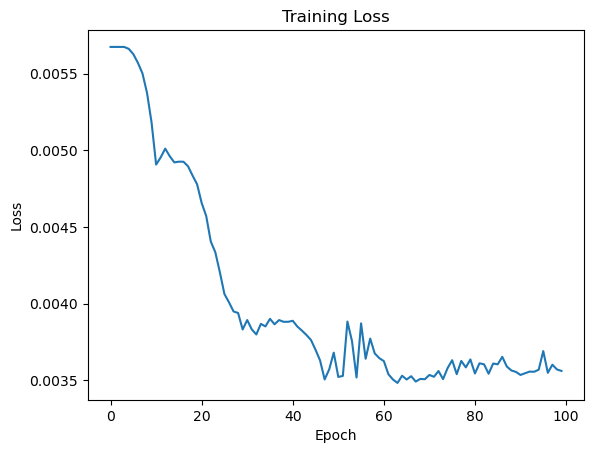

In [82]:
import torch
from torch import nn
import torch.nn.functional as F
import tqdm

class TypeIIMaximumLikelihoodLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Dirichlet distribution D(p|alphas) is used as prior on the likelihood of Multi(y|p)."""
        super().__init__(*args, **kwargs)

    def forward(self, evidences, labels):
        alphas = evidences + 1.0
        strength = torch.sum(alphas, dim=-1, keepdim=True)

        loss = torch.sum(labels * (torch.log(strength) - torch.log(alphas)), dim=-1)

        return torch.mean(loss)

class CEBayesRiskLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Bayes risk is the maximum cost of making incorrect estimates, taking a cost function assigning a penalty of
        making an incorrect estimate and summing it over all possible outcomes. Here the cost function is the Cross Entropy.
        """
        super().__init__(*args, **kwargs)

    def forward(self, evidences, labels):
        alphas = evidences + 1.0
        strengths = torch.sum(alphas, dim=-1, keepdim=True)

        loss = torch.sum(labels * (torch.digamma(strengths) - torch.digamma(alphas)), dim=-1)

        return torch.mean(loss)

class SSBayesRiskLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Same as CEBayesRiskLoss but here the cost function is the sum of squares instead."""
        super().__init__(*args, **kwargs)

    def forward(self, evidences, labels):
        alphas = evidences + 1.0
        strength = torch.sum(alphas, dim=-1, keepdim=True)
        probabilities = alphas / strength

        error = (labels - probabilities) ** 2
        variance = probabilities * (1.0 - probabilities) / (strength + 1.0)

        loss = torch.sum(error + variance, dim=-1)

        return torch.mean(loss)

class KLDivergenceLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Acts as a regularization term to shrink towards zero the evidence of samples that cannot be correctly classified"""
        super().__init__(*args, **kwargs)

    def forward(self, evidences, labels):
        num_classes = evidences.size(-1)
        alphas = evidences + 1.0
        alphas_tilde = labels + (1.0 - labels) * alphas
        strength_tilde = torch.sum(alphas_tilde, dim=-1, keepdim=True)

        # lgamma is the log of the gamma function
        first_term = (
            torch.lgamma(strength_tilde)
            - torch.lgamma(evidences.new_tensor(num_classes, dtype=torch.float32))
            - torch.sum(torch.lgamma(alphas_tilde), dim=-1, keepdim=True)
        )
        second_term = torch.sum(
            (alphas_tilde - 1.0) * (torch.digamma(alphas_tilde) - torch.digamma(strength_tilde)), dim=-1, keepdim=True
        )
        loss = torch.mean(first_term + second_term)

        return loss

class EDLClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.0):
        super().__init__()
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(X_train.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(dropout)
        self.projection_head = nn.Linear(512, num_classes, bias=False)

    def forward(self, x):
        # instead of using regular softmax or sigmoid to output a probability distribution over the classes,
        # we output a positive vector, using a softplus on the logits, as the evidence over the classes
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.projection_head(x)
        return F.relu(x)

    @torch.inference_mode()
    def predict(self, x, return_uncertainty=True):
        evidences = self(x)
        # alphas are the parameters of the Dirichlet distribution that models the probability distribution over the
        # class probabilities and strength is the Dirichlet strength
        alphas = evidences + 1.0
        strength = torch.sum(alphas, dim=-1, keepdim=True)
        probabilities = alphas / strength

        if return_uncertainty:
            total_uncertainty = self.num_classes / strength
            beliefs = evidences / strength
            return probabilities, total_uncertainty, beliefs
        else:
            return probabilities
        

# load your dataset
BATCH_SIZE = 256
MAX_EPOCH = 100
DROPOUT = 0.2
NUM_OF_CLASSES = 2
LR = 1e-3
W_DECAY = 0.005

# Convert y to torch.long, but dont change the shape
# _y_train = torch.tensor(y_train, dtype=torch.long)
# _y_test = torch.tensor(y_test, dtype=torch.long)

print(_X_train.shape, _y_train.shape, _X_test.shape, _y_test.shape)

train_dataloader = DataLoader(TensorDataset(_X_train, _y_train.int()), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(TensorDataset(_X_test, _y_test.int()), batch_size=BATCH_SIZE, shuffle=False)
device = 'cpu'

# encoder can by arbitrary, for example a simple convnet here

model = EDLClassifier(num_classes=NUM_OF_CLASSES, dropout=DROPOUT)
model.to(device)


bayes_risk = SSBayesRiskLoss()
kld_loss = KLDivergenceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=W_DECAY)
model.train()

loss_history = []
best_model = None
best_loss = float('inf')

for epoch in tqdm.tqdm(range(MAX_EPOCH), desc='Training', total=MAX_EPOCH):
    
    loss_epoch = 0
    
    for x, labels in iter(train_dataloader):
        x, labels = x.to(device), labels.to(device)
        # the loss expects the target to be one-hot encoded
        # eye = torch.eye(NUM_OF_CLASSES, dtype=torch.float32, device=device)
        # labels = eye[labels]
        evidences = model(x)

        annealing_coef = min(1.0, epoch / MAX_EPOCH)
        loss = bayes_risk(evidences, labels) + annealing_coef * kld_loss(evidences, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # loss_history.append(loss.item())
        loss_epoch += loss.item()
        
    loss_history.append(loss_epoch / len(x))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        best_model = model.state_dict()
        

# Show the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [83]:
# make predictions with uncertainty

model.load_state_dict(best_model)
model.eval()

predictions, uncertainty, beliefs, labels = [], [], [], []
for x, y in iter(test_dataloader):
    x, y = x.to(device), y.to(device)
    y_pred, u, b = model.predict(x)
    labels.append(y)
    predictions.append(y_pred)
    uncertainty.append(u)
    beliefs.append(b)

labels = torch.concat(labels, dim=0)
predictions = torch.concat(predictions, dim=0)
uncertainty = torch.concat(uncertainty, dim=0)
beliefs = torch.concat(beliefs, dim=0)

# Calculate the accuracy
accuracy = (predictions > 0.5).eq(labels).float().mean().item()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


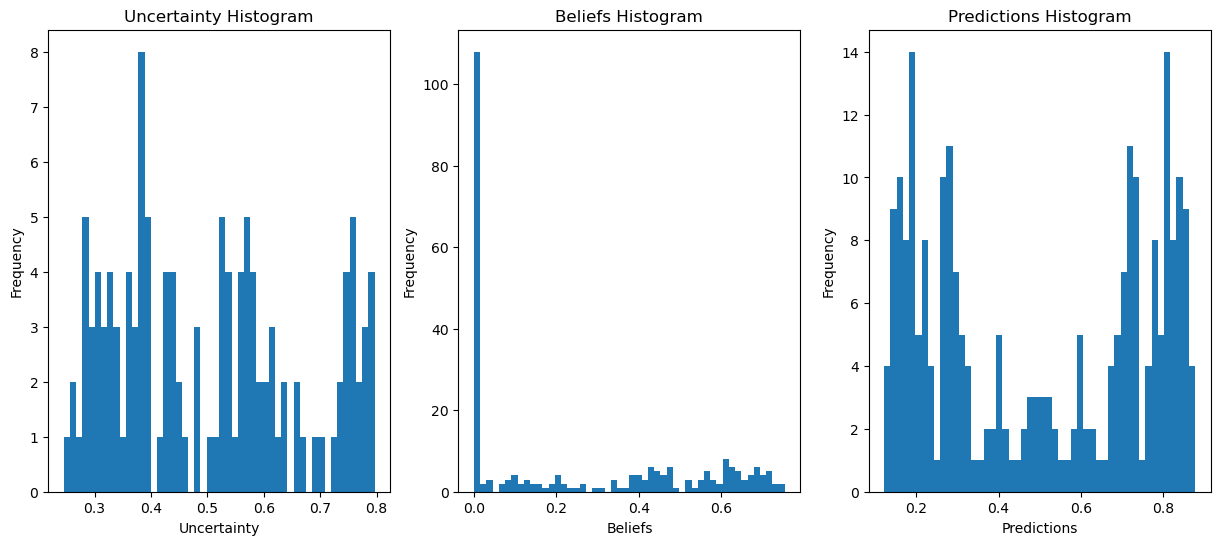

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Plot hisograms 
ax[0].hist(uncertainty.cpu().detach().numpy(), bins=50)
ax[0].set_title('Uncertainty Histogram')
ax[0].set_xlabel('Uncertainty')
ax[0].set_ylabel('Frequency')

ax[1].hist(beliefs.cpu().detach().numpy().flatten(), bins=50)
ax[1].set_title('Beliefs Histogram')
ax[1].set_xlabel('Beliefs')
ax[1].set_ylabel('Frequency')

ax[2].hist(predictions.cpu().detach().numpy().flatten(), bins=50)
ax[2].set_title('Predictions Histogram')
ax[2].set_xlabel('Predictions')
ax[2].set_ylabel('Frequency')

plt.show()

(100, 1) (100, 2)


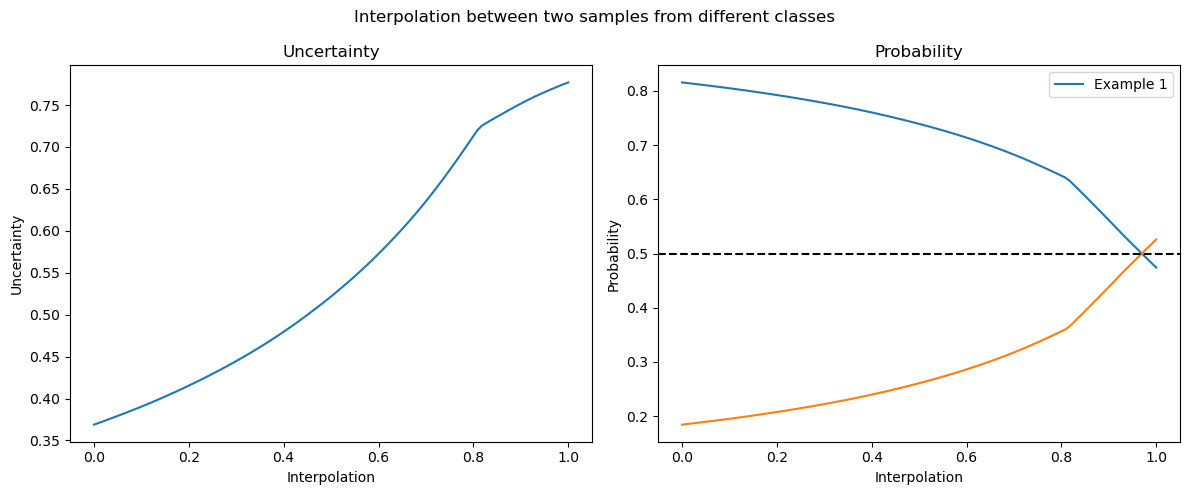

In [85]:
def interpolate_samples():
    n_interp = 100
    
    # Predict classess for all test samples
    y_preds, _, _ = model.predict(_X_test)
    y_preds = y_preds.argmax(dim=-1)
    
    # Find two random samples from different classes
    x1 = _X_test[y_preds == 0][0]
    x2 = _X_test[y_preds == 1][0]
    
    
    x_interp = torch.tensor(np.linspace(x1, x2, n_interp), dtype=torch.float32)
    x_interp = x_interp.to(device)
    
    agg_uncertainty, agg_prob = [], []
    for x in x_interp:
        y_pred, u, b = model.predict(x.unsqueeze(0))
        agg_uncertainty.append(u)
        agg_prob.append(y_pred)
        
    agg_uncertainty = torch.cat(agg_uncertainty, dim=0).cpu().detach().numpy()
    agg_prob = torch.cat(agg_prob, dim=0).cpu().detach().numpy()
    
    
    print(agg_uncertainty.shape, agg_prob.shape)
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    ax[0].plot(np.linspace(0, 1, n_interp), agg_uncertainty, label='Unceertainty')
    ax[1].plot(np.linspace(0, 1, n_interp), agg_prob, label='Probability')
    
    # Plot 0.5 line on ax 1
    ax[1].axhline(0.5, color='black', linestyle='--', label='0.5')
    
    # Unceertainty plot
    ax[0].set_title("Uncertainty")
    ax[0].set_xlabel("Interpolation")
    ax[0].set_ylabel("Uncertainty")
    
    # Probability plot
    ax[1].set_title("Probability")
    ax[1].set_xlabel("Interpolation")
    ax[1].set_ylabel("Probability")
    
    # Add legend
    ax[1].legend([f"Example {i+1}" for i in range(1)])
    
    plt.suptitle("Interpolation between two samples from different classes")
    
    plt.tight_layout()
    plt.show()
    
interpolate_samples()

In [147]:
# Predict some example
example = 20
X_example = _X_test[example]
y_example = _y_test[example]

y_pred, u, b = model.predict(X_example.unsqueeze(0))

print(f"Example {example}")
print(f"True class: {y_example}")
print(f"Predicted class: {y_pred.argmax(dim=-1)}")
print(f'Predicted probability: {y_pred}')
print(f"Uncertainty: {u}")
print(f"Beliefs: {b}")

Example 20
True class: tensor([1., 0.])
Predicted class: tensor([0])
Predicted probability: tensor([[0.8109, 0.1891]])
Uncertainty: tensor([[0.3781]])
Beliefs: tensor([[0.6219, 0.0000]])


Optimized Example 20
True class: tensor([1., 0.])
Predicted class: tensor([0])
Predicted probability: tensor([[0.9100, 0.0900]])
Uncertainty: tensor([[0.1800]])
Beliefs: tensor([[0.8200, 0.0000]])


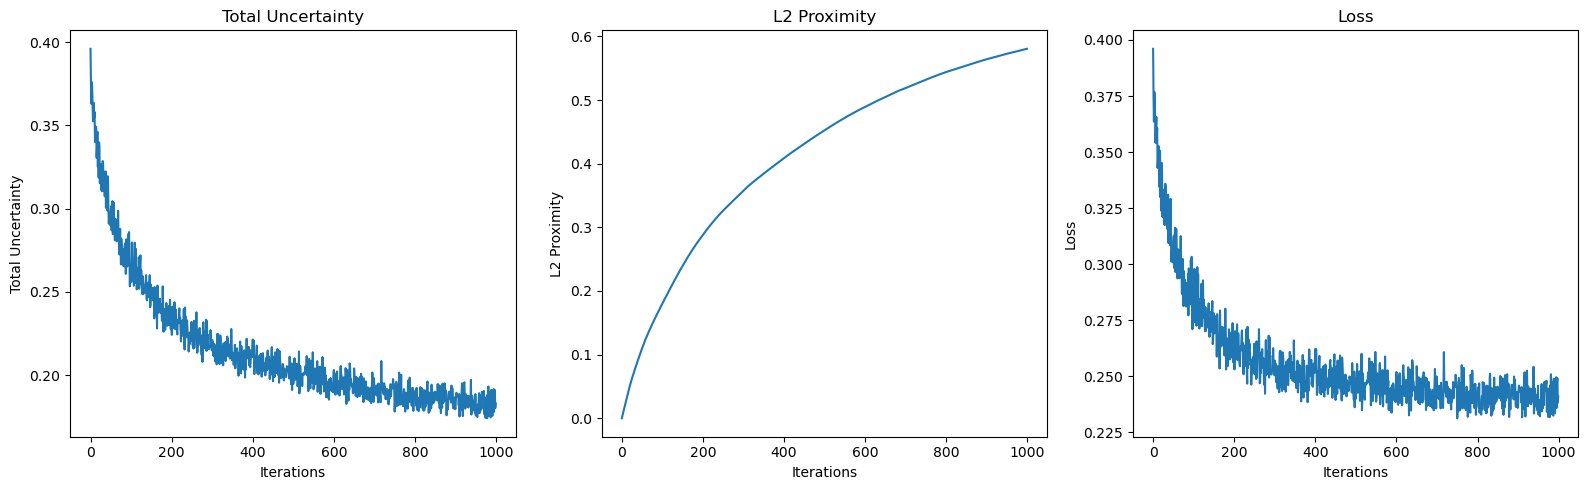

In [148]:
# Optimize X_example to minimize the uncertainty 
X_original = X_example.clone().detach()
X_example = X_example.clone().detach()
X_example.requires_grad = True

# Freeze the model
for param in model.parameters():
    param.requires_grad = False
    
# Optimizer
optimizer = torch.optim.Adam([X_example], lr=1e-3)

LAMBDA_1 = 0.1

tu_history = []
l2_history = []
loss_history = []

for i in range(1000):
    # Forward
    optimizer.zero_grad()
    evidences = model(X_example.unsqueeze(0))
    
    # Calculate the uncertainty
    alphas = evidences + 1.0
    strength = torch.sum(alphas, dim=-1)
    # probabilities = alphas / strength
    # beliefs = evidences / strength
    total_uncertainty = NUM_OF_CLASSES / strength
    
    # Calculate l2 proximity to the original sample
    l2 = torch.norm(X_example - X_original, p=2)
    
    tu_history.append(total_uncertainty.item())
    l2_history.append(l2.item())
    
    # Loss
    loss = total_uncertainty + LAMBDA_1 * l2
    loss_history.append(loss.item())
    
    # Backward
    loss.backward()
    
    # Update
    optimizer.step()
    
y_pred, u, b = model.predict(X_example.unsqueeze(0))
    
print(f"Optimized Example {example}")
print(f"True class: {y_example}")
print(f"Predicted class: {y_pred.argmax(dim=-1)}")
print(f'Predicted probability: {y_pred}')
print(f"Uncertainty: {u}")
print(f"Beliefs: {b}")

# Plot the history
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(tu_history)
ax[0].set_title('Total Uncertainty')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Total Uncertainty')
ax[1].plot(l2_history)
ax[1].set_title('L2 Proximity')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('L2 Proximity')
ax[2].plot(loss_history)
ax[2].set_title('Loss')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('Loss')

plt.tight_layout()
plt.show()